# Notas
- El score es 0 porque busca match perfecto. Usa todos los items, no solo los candidate ya que este set los tiene todos
- Para evaluar usando la web tenemos que devolver 100 items ordenador por session
- Clustering no he podido completar, si alguien lo tiene implementado puede añadirlo

In [47]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import pandas as pd
import numpy as np
import csv
import re
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from utils import MultiHotEncoder, load_model, save_model
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

def capstone_score(model, x_test, y_real, n=100):
    _classes = model.classes_
    y_pred = _classes[np.flip(model.predict_proba(x_test).argsort())]
    scores = []
    for _y_true, _y_pred in zip(y_real, y_pred):
        index=np.where(_y_pred[:n] == _y_true)[0]
        if not index:
            pred_score = 0
        else:
            pred_score = 1/index[0]
        scores.append(pred_score)
    return np.mean(scores)
    

# Read Data

# Selection
## Keep only sessions that purchased a candidate item

In [13]:
candidate_items = pd.read_csv('dressipi_recsys2022/candidate_items.csv', dtype=str)['item_id']

df_p = pd.read_csv('dressipi_recsys2022/train_purchases.csv', parse_dates=['date'], dtype={'item_id': str, 'session_id':int})
df_p = df_p[df_p['item_id'].isin(candidate_items)]
candidate_sessions = df_p['session_id']

df_s = pd.read_csv('dressipi_recsys2022/train_sessions.csv', parse_dates=['date'], dtype={'item_id': str, 'session_id':int})
print(df_s.shape, end=', ')
df_s = df_s[df_s['session_id'].isin(candidate_sessions)]
print(df_s.shape)


(4743820, 3), (2085385, 3)


In [14]:
items_viewed_by_session = df_s.groupby('session_id')['item_id'].unique()

In [5]:
assert (items_viewed_by_session.index == df_p['session_id']).all()

# KMeans

In [56]:
# Transfom data to a series with index the item_id and values the list of features associated to the item_id
df_f = pd.read_csv('dressipi_recsys2022/item_features.csv', dtype='str')
features_by_item = df_f.groupby('item_id')['feature_category_id'].unique()

mlb_kmeans = MultiLabelBinarizer(sparse_output=False)
feature_by_item_mlb = mlb_kmeans.fit_transform(features_by_item)

Exception ignored in: <generator object iter_fields at 0x7f46263b6500>
Traceback (most recent call last):
  File "/home/jano/miniconda3/envs/capstone/lib/python3.10/ast.py", line 254, in iter_fields
    yield field, getattr(node, field)
KeyboardInterrupt: 

KeyboardInterrupt



1
2
3
4
5
6
7
8
9
10
11
12
13
14


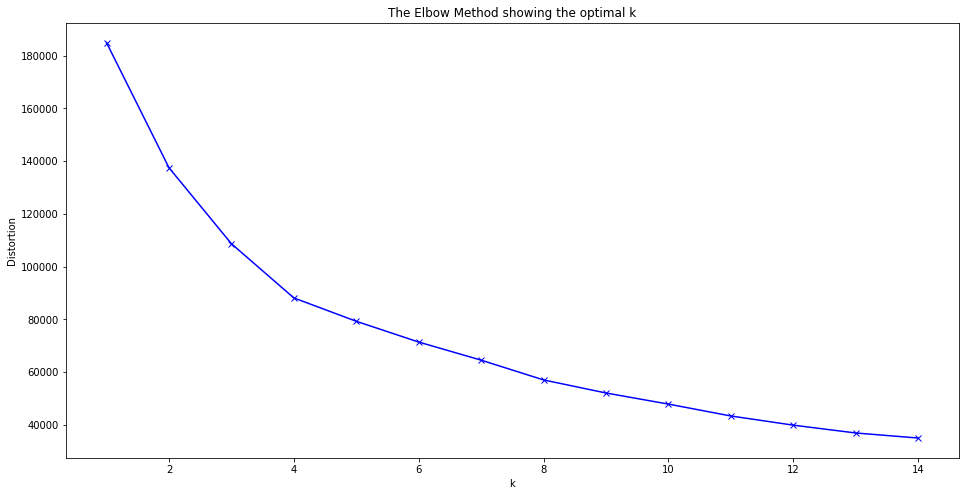

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed 

kmeanmodels = dict()

K = range(1,15,1)

for k in K:
    print(k)
    kmeanmodels[k] = KMeans(n_clusters=k)
    kmeanmodels[k].fit(feature_by_item_mlb)

    distortions = [kmeanmodels[x].inertia_ for x in kmeanmodels]
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [57]:
# Select 4 clusters based on elbow method

In [18]:
# Create a dictionary with item to cluster to map in all_data
n_clusters = 4
item_to_cluster = dict(zip(features_by_item.index, kmeanmodels[n_clusters].predict(feature_by_item_mlb)))

NameError: name 'features_by_item' is not defined

In [10]:
df_s['cluster'] = df_s['item_id'].map(item_to_cluster)
clusters_viewed_by_session = df_s.groupby('session_id')['cluster'].unique()

In [11]:
assert (clusters_viewed_by_session.index==df_p['session_id']).all()

In [12]:
last_seen = df_s.sort_values(['session_id', 'date'], ascending=[True, False]).drop_duplicates(subset='session_id').set_index('session_id')['item_id']
first_seen = df_s.sort_values(['session_id', 'date'], ascending=[True, True]).drop_duplicates(subset='session_id').set_index('session_id')['item_id']

In [13]:
# Add all data in sigle DF to feed the pipeline
all_data = df_p.set_index('session_id').copy()
all_data['items'] = items_viewed_by_session
all_data['clusters'] = clusters_viewed_by_session
all_data['last_seen'] = last_seen
all_data['first_seen'] = first_seen

In [8]:
# Save data to read on demand and require less memory
save_model(all_data, 'data.pkl')

# Feature size comparison (i.e, number of features that would be generated by using different sets of data. Due to massive data/model sizes, only items by session and clusters by sessions are used.

In [20]:
print(f"Items by session: {df_s['item_id'].nunique()} features")
print(f"Clusters by session: {n_clusters} features")
print(f"First item by session: {all_data['last_seen'].nunique()} features")
print(f"Last item by session: {all_data['first_seen'].nunique()} features")

Items by session: 18604 features
Clusters by session: 4 features
First item by session: 15139 features
Last item by session: 15449 features


# For memory porpoises, use only 50% of data for training

In [7]:
all_data = load_model('data.pkl')
train_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(all_data, all_data['item_id'], random_state=42, train_size=train_size)


# Build Pipeline with transformations

In [ ]:
# Transformation pipeline consists on two main parts:

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from utils import MultiHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier

svd_components = 5000
# svd_components = 50
# First, transformation that will take items_by_session and clusters by session and turn them into multihot-sparse matrixes
column_transformer = ColumnTransformer([
    ('items_by_session', MultiHotEncoder(), ['items']), # ~18604
    ('clusters_by_session', MultiHotEncoder(), ['clusters']), # ~4
#     ('first_seen', OneHotEncoder(), ['first_seen']), # ~15449 
#     ('last_seen', OneHotEncoder(), ['last_seen']), # ~15139
    ])
_x = column_transformer.fit_transform(X_train)
del X_train
save_model(column_transformer, 'column_transformer.pkl'); del column_transformer
column_transformer = load_model('column_transformer.pkl')

# Second, the resulting sparse matrix will be feed to TruncatedSVD to reduce the dimensionality. 5000 features were selected as it keept ~90% of information (explained variance ratio) while keeping the number of features somewhat under control
# This train and transform is very time and memory consuming, therefore the result will be saved so that the model can be freed from memory.
tsvd = TruncatedSVD(n_components=svd_components, random_state=42)
_x = tsvd.fit_transform(_x)
print(sum(tsvd.explained_variance_ratio_))
save_model(tsvd, 'tsvd.pkl'); del tsvd
tsvd = load_model('tsvd.pkl')
print(2)

all_transformations = Pipeline([('column_transformer', column_transformer), ('tsvd',tsvd)])
del column_transformer, tsvd
save_model(all_transformations, 'all_transformations.pkl')

save_model(_x, 'X_train_transformed.pkl')
save_model(all_transformations.transform(X_test, 'X_test_transformed.pkl'))

# Train

In [55]:
# Train random forest. Increasing max_depth increases model size exponentially, thus limiting the depth that can be used in a home computer.
# depth of 25 was achieved with 32GB of RAM and 200GB of SWAP.
rfc = RandomForestClassifier(max_depth=3)
for i in list(range(3,14, 2)) + [25]:
    rfc.fit(load_model('X_train_transformed.pkl'), y_train)
    save_model(rfc, 'rfc_{i}.pkl')

# Model size depending on n_samples

In [ ]:
import os
depths = []
sizes = []
for f in os.listdir('.'):
    a = re.search(r'rfc_(\d*)\.pkl', f)
    if a:
        depths.append(int(a.group(1)))
        sizes.append(os.path.getsize(f))

plt.scatter(depths, sizes, linewidths=1, )
plt.xlabel('max_depth')
plt.ylabel('Size in 10Gb')
plt.title('Model size by max_depth')
plt.show()

plt.pyplot.scatter(sizes, depths)
plt.show()


In [ ]:
capstone_score(load_model('rfc_5.pkl'), load_model('X_test_transformed.pkl'), y_test)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
